In [1]:
# Load libraries
import pandas as pd;
import numpy as np;
from sklearn.datasets import load_iris;
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import matplotlib.pyplot as plt
import aux_functions
from aux_functions import plot_with_err

# Model Validation

En este notebook volveremos a trabajar con el dataset iris contenido en scikit-learn.

In [2]:
iris = load_iris();
dat = iris.data;
target = iris.target;
target_names = iris.target_names;

## 1. Data Splitting

Para poder realizar una correcta validación de un modelo de machine learning necesitamos dividir el conjunto de datos en varios subdatasets. Tenemos dos opciones:

- **Conjunto de validación fijo**: Dividiremos el dataset en tres subconjuntos:

    - Muestra de Entrenamiento (TRAINING) : Son los datos con los que se entrenan los modelos.
    
    - Muestra de Validación (VALIDATION) : Se emplea para seleccionar el mejor de los modelos entrenados cuando realizamos el ajuste de parámetros o metamodelización.
    
    - Muestra de Prueba (TEST) : Proporciona el error real esperado con el modelo seleccionado.


- **Cross-validation**: Dividimos el dataset en dos subconjuntos: train y test. Para realizar la metamodelización haremos cross-validation sobre el conjunto de train.

### 1.1 Cross-Validation

Utilizaremos a modo de ejemplo los siguientes ratios:

- **Train**: 85%.


- **Test**: 15%.


In [3]:
perc_values = [0.85, 0.15];

Ahora usemos estos porcentajes y la función  train_test_split de scikit-learn para generar los subconjuntos de train y test.

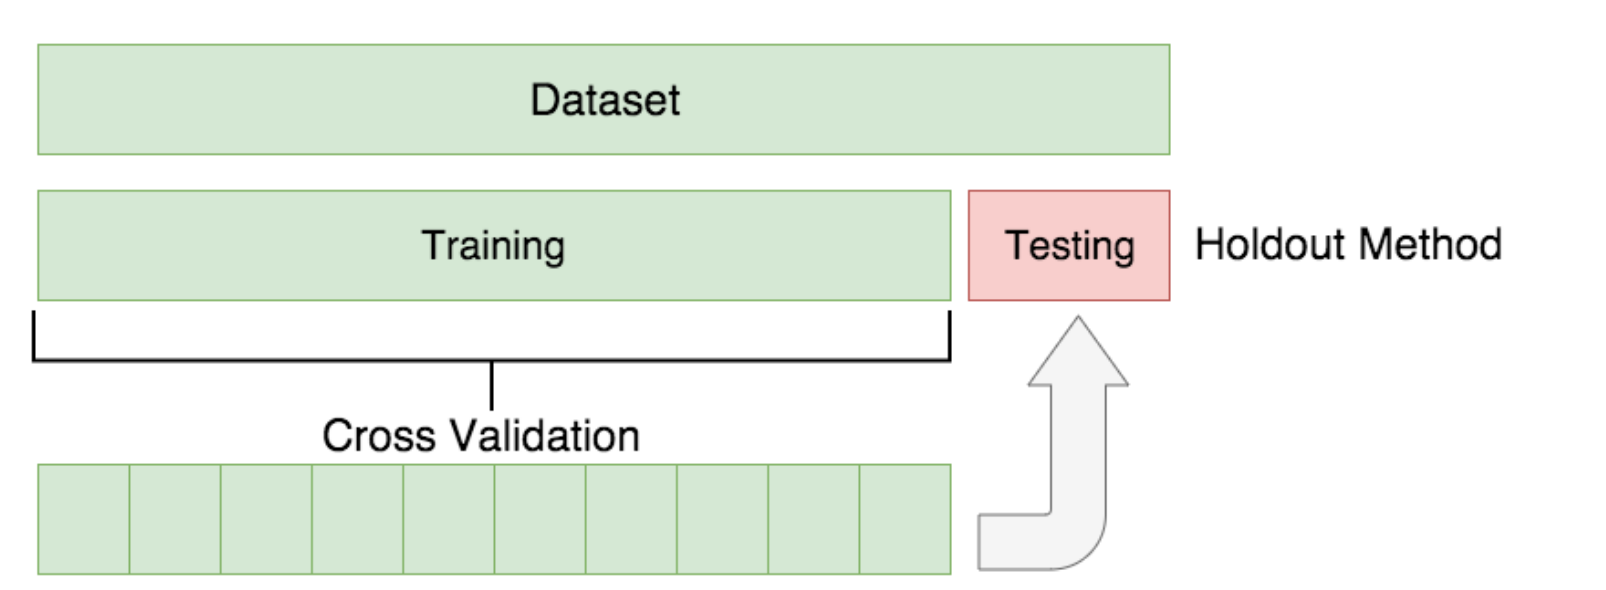

In [4]:
?train_test_split

In [5]:
X_train_cross, X_test_cross, y_train_cross, y_test_cross = 
train_test_split(dat, target, 
                 test_size = perc_values[1], 
                 random_state=1);

Veamos las dimensiones de los dos conjuntos

In [6]:
print('Train data size = ' + str(X_train_cross.shape))
print('Ttrain target size = ' + str(y_train_cross.shape))
print('Test data size = ' + str(X_test_cross.shape))
print('Test target size = ' + str(y_test_cross.shape))

Train data size = (127, 4)
Ttrain target size = (127,)
Test data size = (23, 4)
Test target size = (23,)


### 1.2 Conjunto de Validación Fijo

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

- **Train**: 70%.


- **Validación**: 15%.


- **Test**: 15%.


In [7]:
perc_values = [0.7, 0.15, 0.15];

Ahora usemos estos porcentajes y la función train_test_split de scikit-learn. Dividiremos el conjunto de train anterior (85%) en train (70%) y validación (15%), dejando el test (15%) como está.

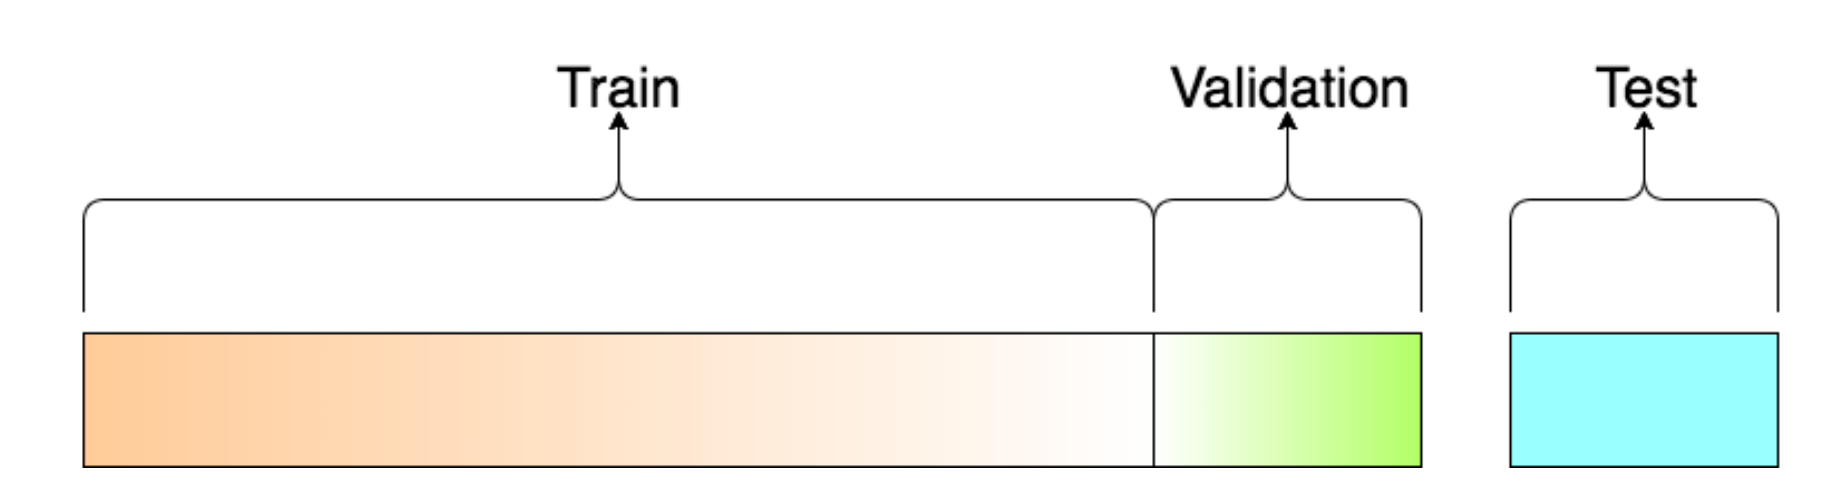

In [11]:
X_train, X_val, y_train, y_val = 
train_test_split(X_train_cross, 
                 y_train_cross, 
                 test_size=(perc_values[1] / (perc_values[0] + perc_values[1])), 
                 random_state=1);
X_test = X_test_cross
y_test = y_test_cross                          

Veamos las dimensiones de los tres conjuntos

In [12]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (104, 4)
Train target size = (104,)
Validation data size = (23, 4)
Validation target size = (23,)
Test data size = (23, 4)
Test target size = (23,)


## 2. Validación Manual

Vamos a realizar ahora la validación de un modelo de KNN para varios valores distintos del hiperparámetro k de forma manual, es decir, realizando explícitamente cada una de las llamadas. Para ello utilizaremos el método del **conjunto de validación fijo**.

### Paso 1: Importar modelo que se quiere emplear

In [13]:
from sklearn.neighbors import KNeighborsClassifier

### Paso 2: Importar métrica a emplear.

In [14]:
from sklearn.metrics import accuracy_score as metric

### Paso 3: Definir modelo

Creamos el modelo para k = 1

In [15]:
knn_1 = KNeighborsClassifier(n_neighbors=1)

Creamos el modelo para k = 3

In [28]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

### Paso 4: Llamar al método fit para entrenar el modelo

Entrenamos ambos modelos usando el conjunto de train

In [29]:
# k = 1
knn_1.fit(X = X_train, y = y_train);

# k = 3
knn_3.fit(X = X_train, y = y_train);

### Paso 5: Llamar al método predict para generar las predicciones

Calculamos las predicciones para train/val/test de cada uno de los modelos

In [30]:
# k = 1
pred_train_1 = knn_1.predict(X_train);
pred_val_1 = knn_1.predict(X_val);

# k = 3
pred_train_3 = knn_3.predict(X_train);
pred_val_3 = knn_3.predict(X_val);

### Paso 6: Calcular métrica usando las predicciones obtenidas en el paso anterior

Y ahora sus correspondientes accuracies

In [31]:
# k = 1
acc_train_1 = metric(y_train, pred_train_1);
acc_val_1 = metric(y_val, pred_val_1);

# k = 3
acc_train_3 = metric(y_train, pred_train_3);
acc_val_3 = metric(y_val, pred_val_3);

Veamos los resultados

In [32]:
# k = 1
print('k = 1 - accuracy train = ' + str(acc_train_1))
print('k = 1 - accuracy val = ' + str(acc_val_1))

# k = 3
print('k = 3 - accuracy train = ' + str(acc_train_3))
print('k = 3 - accuracy val = ' + str(acc_val_3))

k = 1 - accuracy train = 1.0
k = 1 - accuracy val = 0.8695652173913043
k = 3 - accuracy train = 0.9807692307692307
k = 3 - accuracy val = 0.9130434782608695


A la vista de los resultados elegiríamos k = 3 por tener un mayor acierto en validación.

## 3. Curvas de Validación

Vamos a construir ahora unos gráficos que nos permiten analizar el error de validación para toda una serie de valores del hiperparámetro k. Para ello utilizaremos el método de **cross-validation**.

In [33]:
k_values = np.arange(1, 21);
train_scores, val_scores = validation_curve(KNeighborsClassifier(), X_train_cross, y_train_cross,
                                       'n_neighbors', k_values,
                                       scoring = make_scorer(metric))

C:\Users\jesus\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Mostremos ahora los resultados obtenidos (la función plot_with_err puede verse en el script aux_functions.py proporcionado)

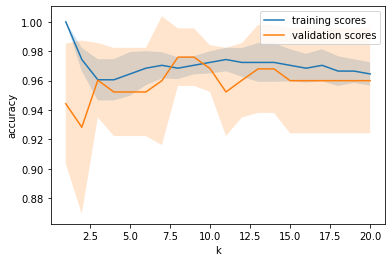

In [34]:
plot_with_err(k_values, train_scores, label='training scores')
plot_with_err(k_values, val_scores, label='validation scores')
plt.xlabel('k'); plt.ylabel('accuracy')
plt.legend();

A la vista de los resultado parece que el valor óptimo sería 8 o 9. Sin embargo, esta forma de elegir los hiperparámetros, basado en un enfoque visual, no parece demasiado científica ni escalable a un caso dónde se tengan varios hiperparámetros a optimizar. 

## 4. Grid Search

Para solucionar estos problemas normalmente el método utilizado para elegir los hiperparámetros es otro, puramente analítico y no visual. Este método se conoce como **grid search** o **búsqueda en rejilla**.

Como hemos visto en clase, el método de grid search consta de los siguientes pasos:

1. Elegimos una familia de modelos.

2. Elegimos unos hiperparámetros a optimizar, les llamaremos par1 y par2. 

3. Para cada hiperparámetro, elegimos una serie de valores a probar.

<img src="figures/grid.png" width="50%">

4. Entrenamos nuestro modelo sobre el conjunto de train con los diferentes hiperparámetros haciendo todas las combinaciones posibles.

5. Hacemos la predicción de los diferentes modelos sobre el conjunto de validación y calculamos el error con la métrica seleccionada.

6. Escogemos el que mejor métrica obtenga y lo aplicamos sobre el conjunto de test para ver el error final esperado de nuestro modelo.



<img src="figures/grid_3.png" width="75%">


Veamos cada uno de estos pasos aplicados a nuestro ejemplo.

### 4.1 Elegimos una familia de modelos

En nuestro estamos trabajando con los modelos KNN.

### 4.2 Elegimos unos hiperparámetros a optimizar

En nuestro caso optimizaremos el hiperparámetro k, o n_neighbors, el único relevante para los modelos de KNN.

### 4.3 Para cada hiperparámetro, elegimos una serie de valores a probar

En nuestro caso vamos a probar todos los valores del 1 al 20, es decir:

In [35]:
k_values = np.arange(1, 21);

### 4.4 Entrenamos nuestro modelo sobre el conjunto de train con los diferentes hiperparámetros haciendo todas las combinaciones posibles / 4.5 Hacemos la predicción de los diferentes modelos sobre el conjunto de validación y calculamos el error con la métrica seleccionada

Realizaremos estos dos pasos en un único bloque de código.

**Conjunto de validación fijo**

In [36]:
grid_results = pd.DataFrame();
for k in k_values:
    # 4.4 Entrenar modelo
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X = X_train, y = y_train)
    
    # 4.5 Generar predicciones
    pred_train = knn.predict(X_train);
    pred_val = knn.predict(X_val);
    
    # 4.5 Calcular métricas de evaluación
    acc_train = metric(y_train, pred_train);
    acc_val = metric(y_val, pred_val);
    
    grid_results = grid_results.append(pd.DataFrame(data={'k':[k],'acc_train':[acc_train],'acc_val':[acc_val]}), ignore_index=True)

Veamos los resultados obtenidos.

In [37]:
grid_results

k  acc_train   acc_val
0    1   1.000000  0.869565
1    2   0.971154  0.913043
2    3   0.980769  0.913043
3    4   0.980769  0.913043
4    5   0.980769  0.869565
5    6   0.980769  0.913043
6    7   0.980769  0.869565
7    8   0.980769  0.913043
8    9   0.980769  0.913043
9   10   0.980769  0.956522
10  11   0.980769  0.913043
11  12   0.980769  0.956522
12  13   0.980769  0.956522
13  14   0.980769  0.956522
14  15   0.971154  0.913043
15  16   0.980769  0.913043
16  17   0.971154  0.913043
17  18   0.980769  0.913043
18  19   0.971154  0.913043
19  20   0.980769  0.913043

En vista de los resultados nos quedaríamos con cualquier valor de k entre 9, 11, 12 o 13 (empatan también en acc_train).

**Cross-validation**

Para este caso scikit-learn dispone de una función que hace los cálculos necesarios de forma automática, **GridSearchCV**.

In [38]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either es

In [40]:
param_grid = [
  {'n_neighbors': k_values}
 ]

Hacemos un 5-fold CV:

In [41]:
grid_results_cv = GridSearchCV(KNeighborsClassifier(), 
                               param_grid, 
                               cv = 5)
grid_results_cv.fit(X_train_cross, y_train_cross)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])}])

In [42]:
print('Values validated for k hyperparameter: ' + str(grid_results_cv.cv_results_['param_n_neighbors']))
print('Validation accuracy: ' + str(grid_results_cv.cv_results_['mean_test_score']))
print('Best score ' + str(grid_results_cv.best_score_))
print('Best k: ' + str(grid_results_cv.best_estimator_.n_neighbors))
best_k = grid_results_cv.best_estimator_.n_neighbors

Values validated for k hyperparameter: [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20]
Validation accuracy: [0.94430769 0.92830769 0.96030769 0.95230769 0.95230769 0.95230769
 0.96       0.976      0.976      0.96830769 0.95230769 0.96030769
 0.968      0.968      0.96       0.96       0.96       0.96
 0.96       0.96      ]
Best score 0.976
Best k: 8


Por tanto, elegiríamos el valor k = 8 (o k = 9).

### 4.6 Escogemos el que mejor métrica obtenga y lo aplicamos sobre el conjunto de test para ver el error final esperado de nuestro modelo

Escogeremos en este el valor k = 8 (k = 9 también sería una opción válida) como valor óptimo para nuestro modelo final. 

Entrenamos el modelo, para ello **juntamos los conjuntos de train y validación**.

In [43]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = np.concatenate((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('New train data size = ' + str(X_train.shape))
print('New train target size = ' + str(y_train.shape))

Train data size = (104, 4)
Train target size = (104,)
Validation data size = (23, 4)
Validation target size = (23,)
New train data size = (127, 4)
New train target size = (127,)


In [44]:
# Entrenar modelo
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X = X_train, y = y_train)

KNeighborsClassifier(n_neighbors=8)

Obtenemos predicciones:    

In [45]:
# Generar predicciones
pred_train = knn.predict(X_train);
pred_test = knn.predict(X_test);    

Calculamos las métricas de evaluación:

In [46]:
# Calcular métricas de evaluación
acc_train = metric(y_train, pred_train);
acc_test = metric(y_test, pred_test);

Veamos los resultados finales:

In [47]:
print('accuracy train = ' + str(acc_train))
print('accuracy test = ' + str(acc_test))

accuracy train = 0.9763779527559056
accuracy test = 1.0
